Zillow Regression Project

By Paige Guajardo

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Custom Imports
import env
import acquire
import evaluate
import explore

# Sklearn 
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

# Other Models
from sklearn.linear_model import LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

# Acquire Data

In [2]:
zillow_df = acquire.get_zillow_data()
df = zillow_df.copy()

df.head()

,id,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt
0,1727539,2017-01-01,3.5,4.0,3100.0,6059.0,2.0,633.0,NaN,0.0,1998.0,1023282.0
1,1387261,2017-01-01,1.0,2.0,1465.0,6111.0,1.0,0.0,NaN,5.0,1967.0,464000.0
2,11677,2017-01-01,2.0,3.0,1243.0,6059.0,2.0,440.0,1.0,6.0,1962.0,564778.0
3,2288172,2017-01-01,3.0,4.0,2376.0,6037.0,NaN,NaN,1.0,0.0,1970.0,145143.0
4,781532,2017-01-01,3.0,4.0,2962.0,6037.0,NaN,NaN,1.0,0.0,1950.0,773303.0


In [3]:
df.shape

(52442, 12)

In [6]:
# Types of counties in california need to seperate to find by counties

In [7]:
df.fips.value_counts()

6037.0    33911
6059.0    14136
6111.0     4395
Name: fips, dtype: int64

In [8]:
df.isnull().sum()

id                                  0
transactiondate                     0
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet       82
fips                                0
garagecarcnt                    34427
garagetotalsqft                 34427
poolcnt                         41346
roomcnt                             0
yearbuilt                         116
taxvaluedollarcnt                   1
dtype: int64

In [9]:
### Early Takeaways

Large number of outliers in some columns

Real estate data may be heavily skewed

If our plan is to remove outliers, could removing outliers also reduce our null count?

# Prep Data

In [10]:
# Fill pools, garagae and garage count with 0s

In [11]:
df[['garagecarcnt', 'garagetotalsqft', 'poolcnt']] = df[['garagecarcnt', 'garagetotalsqft', 'poolcnt']].fillna(0)

In [12]:
df.isnull().sum()

id                                0
transactiondate                   0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet     82
fips                              0
garagecarcnt                      0
garagetotalsqft                   0
poolcnt                           0
roomcnt                           0
yearbuilt                       116
taxvaluedollarcnt                 1
dtype: int64

In [13]:
# Drop all nulls

In [14]:
df = df.dropna()

In [15]:
df.isnull().sum()

id                              0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
garagecarcnt                    0
garagetotalsqft                 0
poolcnt                         0
roomcnt                         0
yearbuilt                       0
taxvaluedollarcnt               0
dtype: int64

In [16]:
df.shape

(52320, 12)

In [17]:
df.head()

,id,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt
0,1727539,2017-01-01,3.5,4.0,3100.0,6059.0,2.0,633.0,0.0,0.0,1998.0,1023282.0
1,1387261,2017-01-01,1.0,2.0,1465.0,6111.0,1.0,0.0,0.0,5.0,1967.0,464000.0
2,11677,2017-01-01,2.0,3.0,1243.0,6059.0,2.0,440.0,1.0,6.0,1962.0,564778.0
3,2288172,2017-01-01,3.0,4.0,2376.0,6037.0,0.0,0.0,1.0,0.0,1970.0,145143.0
4,781532,2017-01-01,3.0,4.0,2962.0,6037.0,0.0,0.0,1.0,0.0,1950.0,773303.0


In [18]:
# Change yearbuilt to age

In [19]:
acquire.yearbuilt_years(df)
df.head()

,id,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt,age
0,1727539,2017-01-01,3.5,4.0,3100.0,6059.0,2.0,633.0,0.0,0.0,1998,1023282.0,23
1,1387261,2017-01-01,1.0,2.0,1465.0,6111.0,1.0,0.0,0.0,5.0,1967,464000.0,54
2,11677,2017-01-01,2.0,3.0,1243.0,6059.0,2.0,440.0,1.0,6.0,1962,564778.0,59
3,2288172,2017-01-01,3.0,4.0,2376.0,6037.0,0.0,0.0,1.0,0.0,1970,145143.0,51
4,781532,2017-01-01,3.0,4.0,2962.0,6037.0,0.0,0.0,1.0,0.0,1950,773303.0,71


In [20]:
df.transactiondate.value_counts()

2017-06-30    807
2017-04-28    615
2017-05-31    563
2017-07-28    545
2017-08-31    528
             ... 
2017-09-20      1
2017-03-25      1
2017-09-17      1
2017-05-07      1
2017-05-20      1
Name: transactiondate, Length: 258, dtype: int64

In [21]:
df.describe()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt,age
count,5.232000e+04,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,52320.000000,5.232000e+04,52320.000000
mean,1.497316e+06,2.302781,3.305906,1922.537309,6049.085168,0.669954,170.444973,0.211907,1.893693,1963.394438,5.280717e+05,57.605562
std,8.595537e+05,1.019058,0.940568,1003.615675,20.984528,0.979840,252.763455,0.408664,3.146052,23.133385,7.484542e+05,23.133385
min,3.490000e+02,0.000000,0.000000,128.000000,6037.000000,0.000000,0.000000,0.000000,0.000000,1878.000000,1.000000e+03,5.000000
25%,7.577620e+05,2.000000,3.000000,1268.000000,6037.000000,0.000000,0.000000,0.000000,0.000000,1950.000000,1.937155e+05,42.000000
50%,1.500634e+06,2.000000,3.000000,1658.000000,6037.000000,0.000000,0.000000,0.000000,0.000000,1961.000000,3.733765e+05,60.000000
75%,2.242017e+06,3.000000,4.000000,2305.000000,6059.000000,2.000000,430.000000,0.000000,5.000000,1979.000000,6.186230e+05,71.000000
max,2.982270e+06,18.000000,14.000000,21929.000000,6111.000000,14.000000,4251.000000,1.000000,15.000000,2016.000000,4.906124e+07,143.000000


In [22]:
# Function to get list of items that are objects

In [23]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # create a mask of columns whether they are object type or not
    mask = np.array(df.dtypes == "object")

        
    # get a list of the column names that are objects (from the mask)
    object_cols = df.iloc[:, mask].columns.tolist()
    
    return object_cols

In [24]:
get_object_cols(df)

['transactiondate']

In [25]:
# Dropping object type columns with dates

In [26]:
df = df.drop(columns = ['transactiondate'])
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,poolcnt,roomcnt,yearbuilt,taxvaluedollarcnt,age
0,1727539,3.5,4.0,3100.0,6059.0,2.0,633.0,0.0,0.0,1998,1023282.0,23
1,1387261,1.0,2.0,1465.0,6111.0,1.0,0.0,0.0,5.0,1967,464000.0,54
2,11677,2.0,3.0,1243.0,6059.0,2.0,440.0,1.0,6.0,1962,564778.0,59
3,2288172,3.0,4.0,2376.0,6037.0,0.0,0.0,1.0,0.0,1970,145143.0,51
4,781532,3.0,4.0,2962.0,6037.0,0.0,0.0,1.0,0.0,1950,773303.0,71


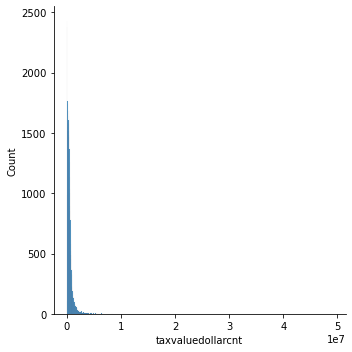

In [27]:
sns.displot(x='taxvaluedollarcnt', data=df)

In [28]:
df = df.rename(columns = {'fips':'county', 'calculatedfinishedsquarefeet' : 'area', 'bathroomcnt' : 'bathrooms',
                         'bedroomcnt' : 'bedrooms', 'poolcnt' : 'pools', 'garagecarcnt' : 'garages',
                          'taxvaluedollarcnt': 'tax_value'})

In [29]:
df['LA_County']= df['county'] == 6037
df['Orange_County']= df['county'] == 6059
df['Ventura_County']= df['county'] == 6111


In [30]:
df['county'] = df['county'].astype(object)

In [31]:
df['county'] = df.county.replace(6059, 'Orange')
df['county'] = df.county.replace(6037, 'LA')
df['county'] = df.county.replace(6111, 'Ventura')

df.head()

,id,bathrooms,bedrooms,area,county,garages,garagetotalsqft,pools,roomcnt,yearbuilt,tax_value,age,LA_County,Orange_County,Ventura_County
0,1727539,3.5,4.0,3100.0,Orange,2.0,633.0,0.0,0.0,1998,1023282.0,23,False,True,False
1,1387261,1.0,2.0,1465.0,Ventura,1.0,0.0,0.0,5.0,1967,464000.0,54,False,False,True
2,11677,2.0,3.0,1243.0,Orange,2.0,440.0,1.0,6.0,1962,564778.0,59,False,True,False
3,2288172,3.0,4.0,2376.0,LA,0.0,0.0,1.0,0.0,1970,145143.0,51,True,False,False
4,781532,3.0,4.0,2962.0,LA,0.0,0.0,1.0,0.0,1950,773303.0,71,True,False,False


In [32]:
df['LA_County'] = df['LA_County'].replace(False, 0)
df['LA_County'] = df['LA_County'].replace(True, 1)

df['Orange_County'] = df['Orange_County'].replace(False, 0)
df['Orange_County'] = df['Orange_County'].replace(True, 1)

df['Ventura_County'] = df['Ventura_County'].replace(False, 0)
df['Ventura_County'] = df['Ventura_County'].replace(True, 1)


df.head()

,id,bathrooms,bedrooms,area,county,garages,garagetotalsqft,pools,roomcnt,yearbuilt,tax_value,age,LA_County,Orange_County,Ventura_County
0,1727539,3.5,4.0,3100.0,Orange,2.0,633.0,0.0,0.0,1998,1023282.0,23,0,1,0
1,1387261,1.0,2.0,1465.0,Ventura,1.0,0.0,0.0,5.0,1967,464000.0,54,0,0,1
2,11677,2.0,3.0,1243.0,Orange,2.0,440.0,1.0,6.0,1962,564778.0,59,0,1,0
3,2288172,3.0,4.0,2376.0,LA,0.0,0.0,1.0,0.0,1970,145143.0,51,1,0,0
4,781532,3.0,4.0,2962.0,LA,0.0,0.0,1.0,0.0,1950,773303.0,71,1,0,0


In [33]:
df = df.drop(columns = ['yearbuilt'])

In [34]:
df.head()

,id,bathrooms,bedrooms,area,county,garages,garagetotalsqft,pools,roomcnt,tax_value,age,LA_County,Orange_County,Ventura_County
0,1727539,3.5,4.0,3100.0,Orange,2.0,633.0,0.0,0.0,1023282.0,23,0,1,0
1,1387261,1.0,2.0,1465.0,Ventura,1.0,0.0,0.0,5.0,464000.0,54,0,0,1
2,11677,2.0,3.0,1243.0,Orange,2.0,440.0,1.0,6.0,564778.0,59,0,1,0
3,2288172,3.0,4.0,2376.0,LA,0.0,0.0,1.0,0.0,145143.0,51,1,0,0
4,781532,3.0,4.0,2962.0,LA,0.0,0.0,1.0,0.0,773303.0,71,1,0,0


# Explore Data

## Visualizing some of the data and outliers

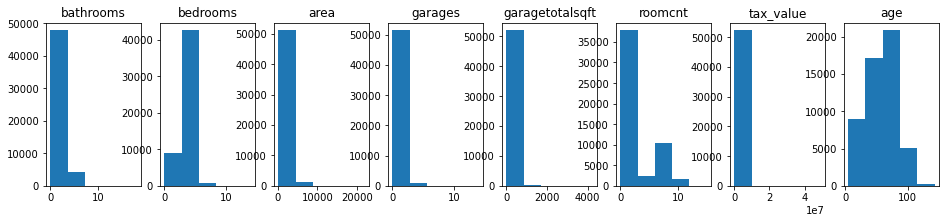

In [35]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['county', 'id', 'LA_County', 'Orange_County',
                                                 'Ventura_County', 'pools']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
plt.show()

In [36]:
### Takeaways

Most seem heavily skewed besides age

tax_value is heavily skewed

In [37]:
### Looking at outliers

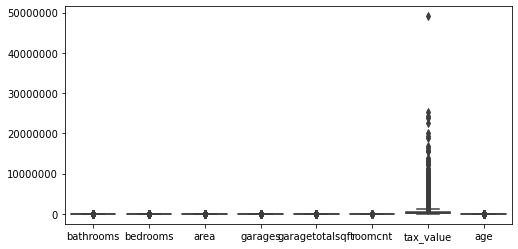

In [38]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=df.drop(columns=['county', 'id', 'LA_County', 'Orange_County',
                                                 'Ventura_County', 'pools']))

plt.show()

In [39]:
### Looking at outliers closer!

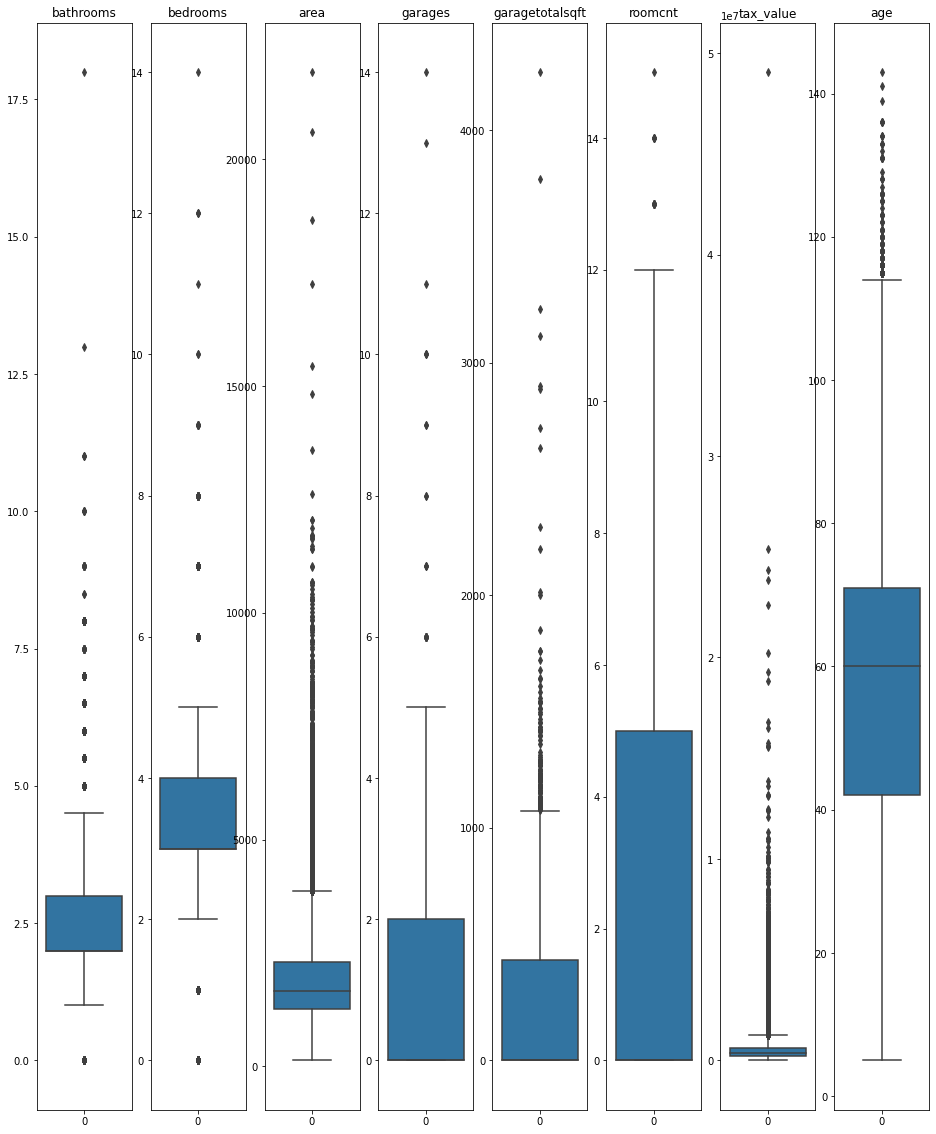

In [40]:
# List of columns
cols = [col for col in df.columns if col not in ['county', 'id', 'LA_County', 'Orange_County',
                                                 'Ventura_County', 'pools']]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

In [41]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''

    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [42]:
 # removing outliers
col_list = ['bedrooms', 'bathrooms', 'area', 'tax_value', 'garages', 'roomcnt', 'garagetotalsqft']
k = 1.5
    
df = remove_outliers(df, k, col_list)

In [43]:
df.shape

(45573, 14)

In [44]:
df.head()

,id,bathrooms,bedrooms,area,county,garages,garagetotalsqft,pools,roomcnt,tax_value,age,LA_County,Orange_County,Ventura_County
0,1727539,3.5,4.0,3100.0,Orange,2.0,633.0,0.0,0.0,1023282.0,23,0,1,0
1,1387261,1.0,2.0,1465.0,Ventura,1.0,0.0,0.0,5.0,464000.0,54,0,0,1
2,11677,2.0,3.0,1243.0,Orange,2.0,440.0,1.0,6.0,564778.0,59,0,1,0
3,2288172,3.0,4.0,2376.0,LA,0.0,0.0,1.0,0.0,145143.0,51,1,0,0
4,781532,3.0,4.0,2962.0,LA,0.0,0.0,1.0,0.0,773303.0,71,1,0,0


### Revisualize the data

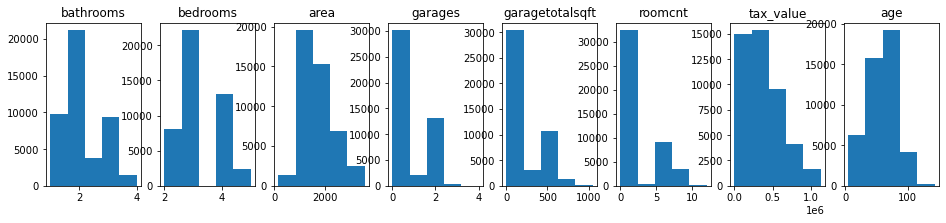

In [45]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['county', 'id', 'LA_County', 'Orange_County',
                                                 'Ventura_County', 'pools']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
plt.show()

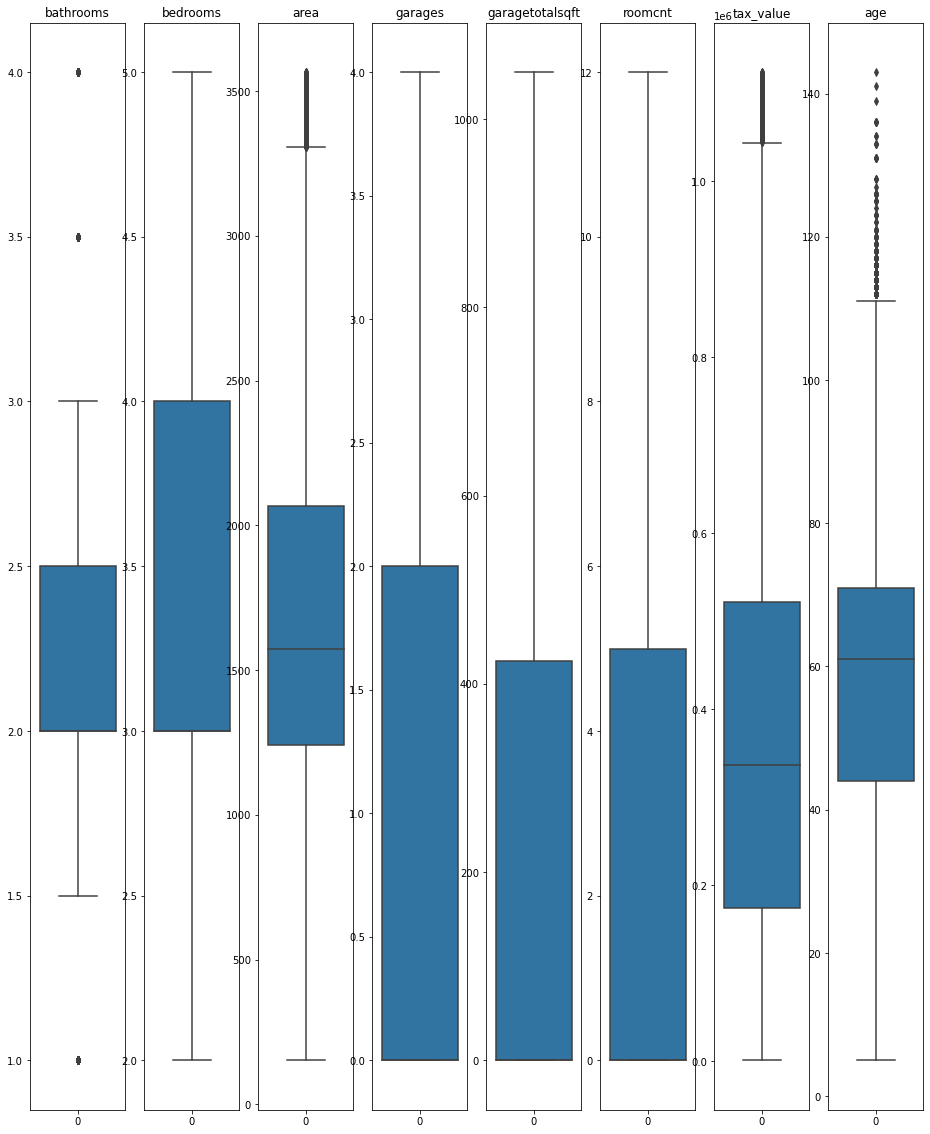

In [46]:
# List of columns
cols = [col for col in df.columns if col not in ['county', 'id', 'LA_County', 'Orange_County',
                                                 'Ventura_County', 'pools']]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

(array([14932., 15324.,  9526.,  4135.,  1656.]),
 array([1.000000e+03, 2.256002e+05, 4.502004e+05, 6.748006e+05,
        8.994008e+05, 1.124001e+06]),
 <BarContainer object of 5 artists>)

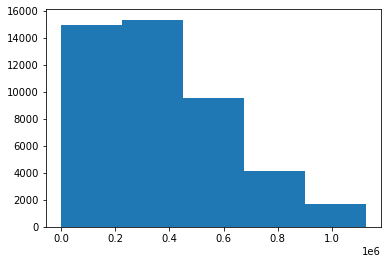

In [47]:
plt.hist(x= 'tax_value', bins = 5, data = df)

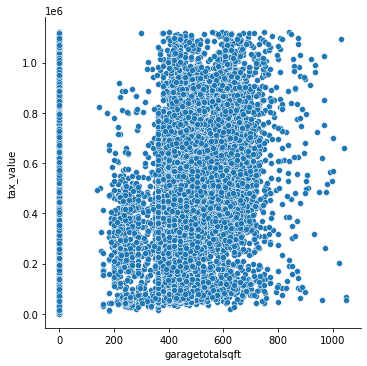

In [48]:
sns.relplot(x = 'garagetotalsqft', y = 'tax_value', data = df, kind = 'scatter')

In [49]:
train, validate, test = acquire.split_data(df)

## Counties and tax value

<AxesSubplot:xlabel='county', ylabel='tax_value'>

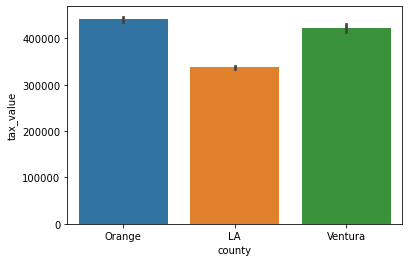

In [50]:
sns.barplot(x = 'county', y = 'tax_value', data = train)

In [51]:
#sns.swarmplot(x='county', y='tax_value', data=df)

<AxesSubplot:xlabel='county', ylabel='tax_value'>

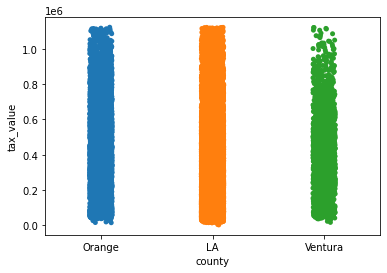

In [52]:
sns.stripplot(x='county', y='tax_value', data=train)

<AxesSubplot:xlabel='county', ylabel='tax_value'>

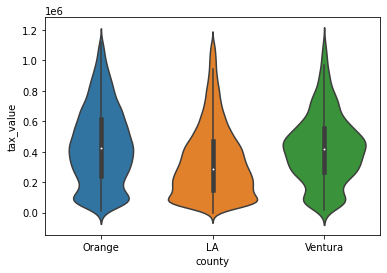

In [53]:
sns.violinplot(x='county', y='tax_value', data=train)

<AxesSubplot:xlabel='county', ylabel='tax_value'>

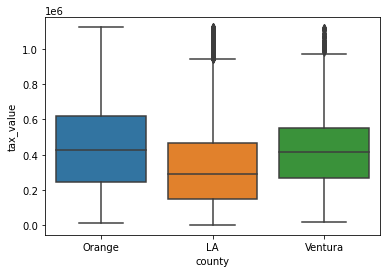

In [54]:
sns.boxplot(x='county', y='tax_value', data=train)

<AxesSubplot:xlabel='Orange_County', ylabel='tax_value'>

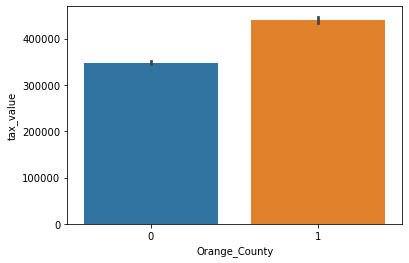

In [55]:
sns.barplot(y = 'tax_value', x = 'Orange_County', data = train)

In [56]:
# t-test 2 different poplulations, independent
# county is driver

H0: Mean of tax value of orange county == mean of tax values of all other counties
    
Ha: Mean of tax value of orange county != mean of tax value of all other counties

In [57]:
alpha = 0.05
sample = train[train.county == 'Orange'].tax_value
overall_mean = train.tax_value.mean()

t, p = stats.ttest_1samp(sample, overall_mean)

print(t, p/2, alpha)

22.28918277432004 1.5532616455130103e-106 0.05


In [58]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


## Age and Taxvalue

In [59]:
train.shape

(25520, 14)

(0.0, 2000000.0)

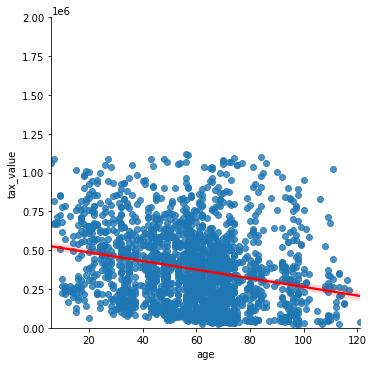

In [60]:
sns.lmplot(data = train.sample(2000), x = 'age', y = 'tax_value',line_kws={'color': 'red'})
plt.ylim(0,2000000)

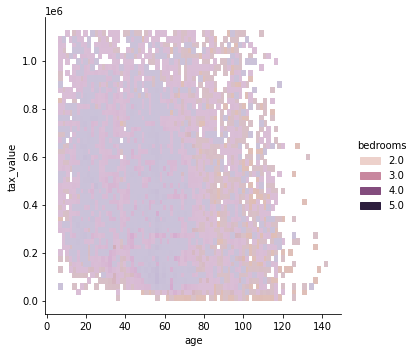

In [61]:
sns.displot(x = 'age', y = 'tax_value', data = train, hue = 'bedrooms')

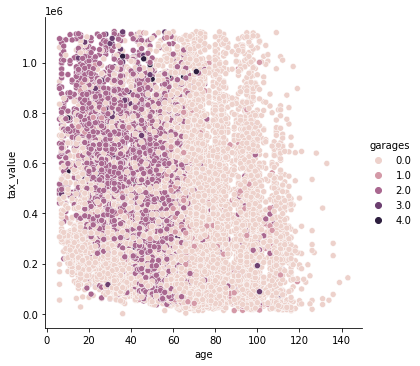

In [62]:
sns.relplot(x = 'age', y = 'tax_value', data = train, hue = 'garages', kind = 'scatter')

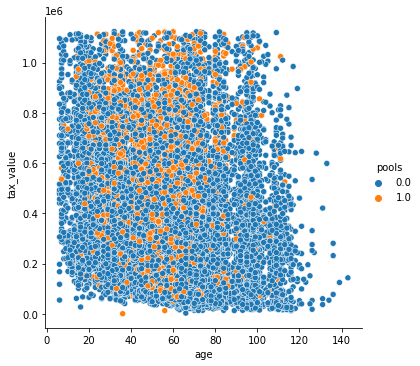

In [63]:
sns.relplot(x = 'age', y = 'tax_value', data = train, hue = 'pools', kind = 'scatter')

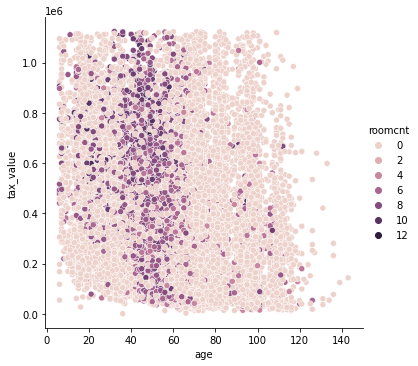

In [64]:
sns.relplot(x = 'age', y = 'tax_value', data = train, hue = 'roomcnt', kind = 'scatter')

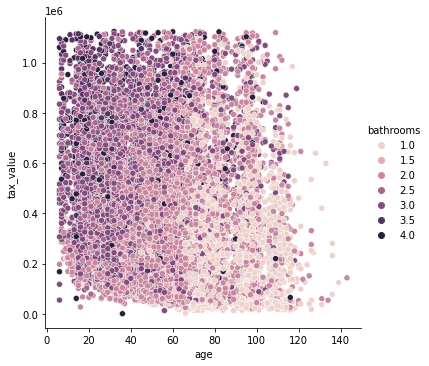

In [65]:
sns.relplot(x = 'age', y = 'tax_value', data = train, hue = 'bathrooms', kind = 'scatter')

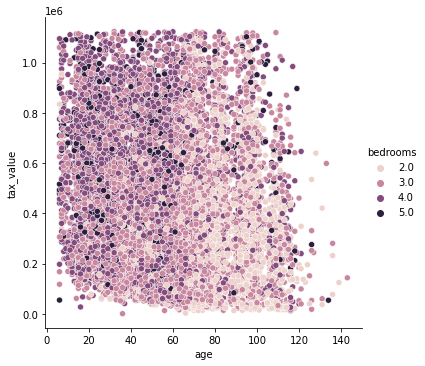

In [66]:
sns.relplot(x = 'age', y = 'tax_value', data = train, hue = 'bedrooms', kind = 'scatter')

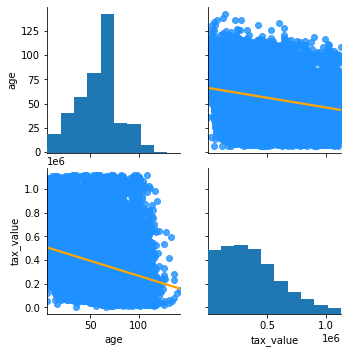

In [67]:
explore.plot_variable_pairs(train[['age', 'tax_value']])

In [68]:
# Pearsons R , finding a linear relationship between age and tax value
# age is a driver

H0: There is not linear correlation between the tax value and the age of the house.

HA: There is linear correlation between the tax value and the age of the house.

In [69]:
test_results = stats.pearsonr(train.tax_value, train.age)
r, p = test_results
print("r: ", r, "p: ", p)

r:  -0.22784050801640257 p:  9.04901470162524e-298


In [70]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


## Area and Taxvalue

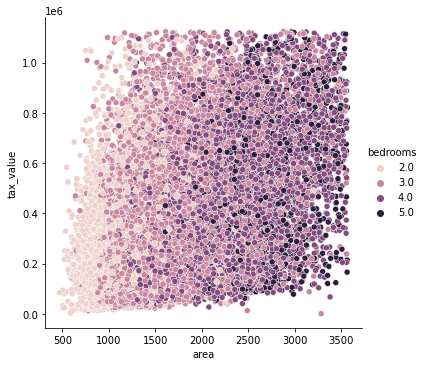

In [71]:
sns.relplot(x = 'area', y = 'tax_value', data = train, hue = 'bedrooms', kind = 'scatter')

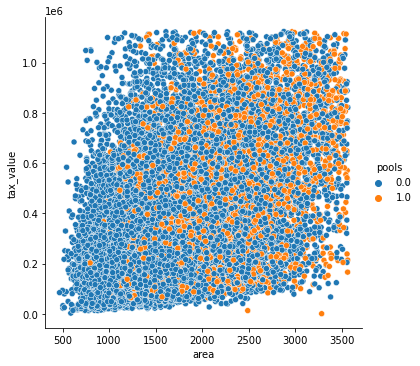

In [72]:
sns.relplot(x = 'area', y = 'tax_value', data = train, hue = 'pools', kind = 'scatter')

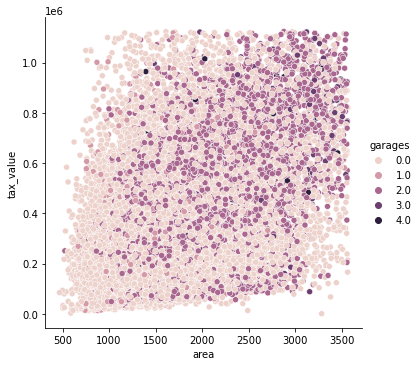

In [73]:
sns.relplot(x = 'area', y = 'tax_value', data = train, hue = 'garages', kind = 'scatter')

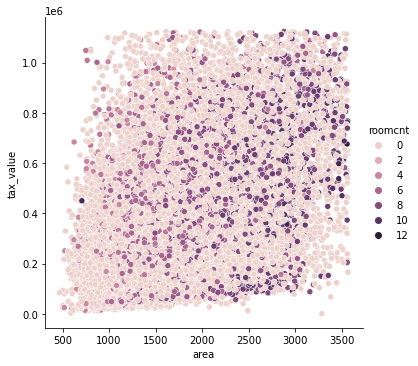

In [74]:
sns.relplot(x = 'area', y = 'tax_value', data = train, hue = 'roomcnt', kind = 'scatter')

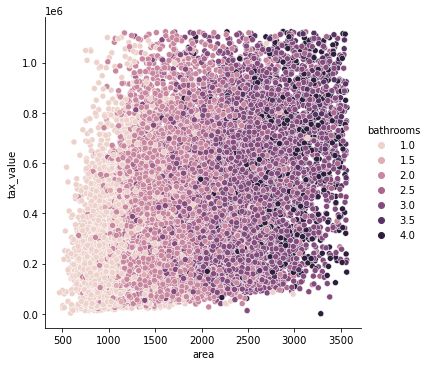

In [75]:
sns.relplot(x = 'area', y = 'tax_value', data = train, hue = 'bathrooms', kind = 'scatter')

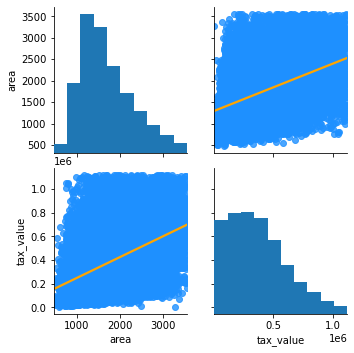

In [76]:
explore.plot_variable_pairs(train[['area', 'tax_value']])

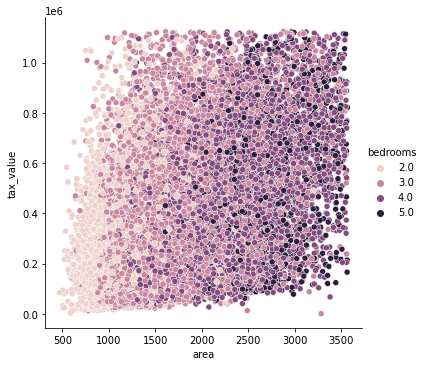

In [77]:
sns.relplot(x = 'area', y = 'tax_value', data = train, hue = 'bedrooms', kind = 'scatter')

## Number of pools and taxvalue

<AxesSubplot:xlabel='pools', ylabel='tax_value'>

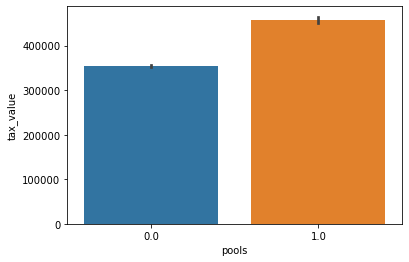

In [78]:
sns.barplot(data = train, x = 'pools', y = 'tax_value')

<AxesSubplot:xlabel='pools', ylabel='tax_value'>

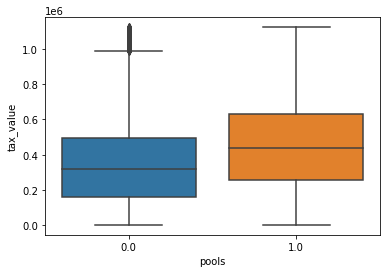

In [79]:
sns.boxplot(x='pools', y='tax_value', data=train)


<AxesSubplot:xlabel='pools', ylabel='tax_value'>

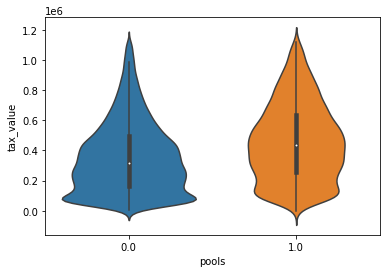

In [80]:
sns.violinplot(x='pools', y='tax_value', data=train)

## Creating Model

In [82]:
train.head()

,id,bathrooms,bedrooms,area,county,garages,garagetotalsqft,pools,roomcnt,tax_value,age,LA_County,Orange_County,Ventura_County
45337,536051,2.5,3.0,1927.0,Orange,2.0,446.0,0.0,0.0,551076.0,18,0,1,0
45534,129450,1.0,2.0,924.0,LA,0.0,0.0,0.0,0.0,319803.0,64,1,0,0
20230,464200,1.0,3.0,1042.0,LA,0.0,0.0,0.0,0.0,855652.0,90,1,0,0
38945,2475863,1.0,2.0,1089.0,Ventura,1.0,360.0,0.0,5.0,40638.0,96,0,0,1
22988,2618380,2.0,4.0,1169.0,LA,0.0,0.0,0.0,0.0,182143.0,70,1,0,0


In [83]:

#train = train.drop(columns = ['id'])
train = train.drop(columns = ['id', 'county'])

In [84]:
X_train = train.drop(columns = ['tax_value'])
y_train = train.tax_value

In [85]:
train

,bathrooms,bedrooms,area,garages,garagetotalsqft,pools,roomcnt,tax_value,age,LA_County,Orange_County,Ventura_County
45337,2.5,3.0,1927.0,2.0,446.0,0.0,0.0,551076.0,18,0,1,0
45534,1.0,2.0,924.0,0.0,0.0,0.0,0.0,319803.0,64,1,0,0
20230,1.0,3.0,1042.0,0.0,0.0,0.0,0.0,855652.0,90,1,0,0
38945,1.0,2.0,1089.0,1.0,360.0,0.0,5.0,40638.0,96,0,0,1
22988,2.0,4.0,1169.0,0.0,0.0,0.0,0.0,182143.0,70,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44773,1.0,2.0,869.0,0.0,0.0,0.0,0.0,155139.0,71,1,0,0
50064,3.0,4.0,2298.0,0.0,0.0,1.0,0.0,173744.0,60,1,0,0
46526,2.0,3.0,2037.0,0.0,0.0,1.0,0.0,289321.0,44,1,0,0
11208,1.0,3.0,1140.0,2.0,437.0,0.0,6.0,160831.0,68,0,1,0


## Scaling The Data

In [86]:
# Robust Scaler for the outliers still in here even after using a outlier remover
scaler = sklearn.preprocessing.RobustScaler()

scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)

x_train_scaled = pd.DataFrame(x_train_scaled, columns = X_train.columns.to_list())

In [87]:
x_train_scaled

,bathrooms,bedrooms,area,garages,garagetotalsqft,pools,roomcnt,age,LA_County,Orange_County,Ventura_County
0,1.0,0.0,0.431540,1.0,1.056872,0.0,0.0,-1.592593,-1.0,1.0,0.0
1,-2.0,-1.0,-0.794621,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0
2,-2.0,0.0,-0.650367,0.0,0.000000,0.0,0.0,1.074074,0.0,0.0,0.0
3,-2.0,-1.0,-0.592910,0.5,0.853081,0.0,1.0,1.296296,-1.0,0.0,1.0
4,0.0,1.0,-0.495110,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
25515,-2.0,-1.0,-0.861858,0.0,0.000000,0.0,0.0,0.370370,0.0,0.0,0.0
25516,2.0,1.0,0.885086,0.0,0.000000,1.0,0.0,-0.037037,0.0,0.0,0.0
25517,0.0,0.0,0.566015,0.0,0.000000,1.0,0.0,-0.629630,0.0,0.0,0.0
25518,-2.0,0.0,-0.530562,1.0,1.035545,0.0,1.2,0.259259,-1.0,1.0,0.0


In [88]:
##### Feature stuff later (SELECT K BEST, AND RFE)

In [89]:
# SElect K best
f_selector = SelectKBest(f_regression, k=3)

# find top 3 correlated to target variable
f_selector.fit(x_train_scaled, y_train)

# bool mask of whether the columns was selected or not
feature_mask = f_selector.get_support()

# Get list of K features
f_feature = x_train_scaled.iloc[:,feature_mask].columns.tolist()

f_feature

['bathrooms', 'area', 'garagetotalsqft']

In [90]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 3)

# fit the data using RFE
rfe.fit(x_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = x_train_scaled.iloc[:,feature_mask].columns.tolist()

rfe_feature

['area', 'roomcnt', 'LA_County']

## Testing Baseline Accuracy

In [91]:
# Setting y_train to a data frame
y_train = pd.DataFrame(y_train)

y_train['baseline_mean'] = y_train['tax_value'].mean()
y_train['baseline_med'] = y_train['tax_value'].median()

In [92]:
# Test RMSE Value


rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_mean)**(1/2)
rmse_train2 = mean_squared_error(y_train.tax_value, y_train.baseline_med)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train2, 2))

RMSE using Median
Train/In-Sample:  246549.52


In [93]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2))

RMSE using Mean
Train/In-Sample:  243918.77


## MOdeling

### OLS MOdel

In [94]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train_ols = mean_squared_error(y_train.tax_value, y_train.tax_pred_lm)**(1/2)

# predict validate
#y_validate['G3_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
#rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols)
      #"\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  213014.01669734885


## Laso R

In [95]:
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.tax_value, y_train.tax_pred_lars)**(1/2)

# predict validate
#y_validate['G3_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
#rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars) 
      #"\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  213015.9924506074


## Polynomial 

In [96]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
#X_validate_degree2 = pf.transform(X_validate)
#X_test_degree2 = pf.transform(X_test)

In [97]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_train.tax_value, y_train.tax_pred_lm2)**(1/2)

# predict validate
#y_validate['G3_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
#rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_poly)
      #"\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  209766.4432258845


# Plotting actual vs predicted

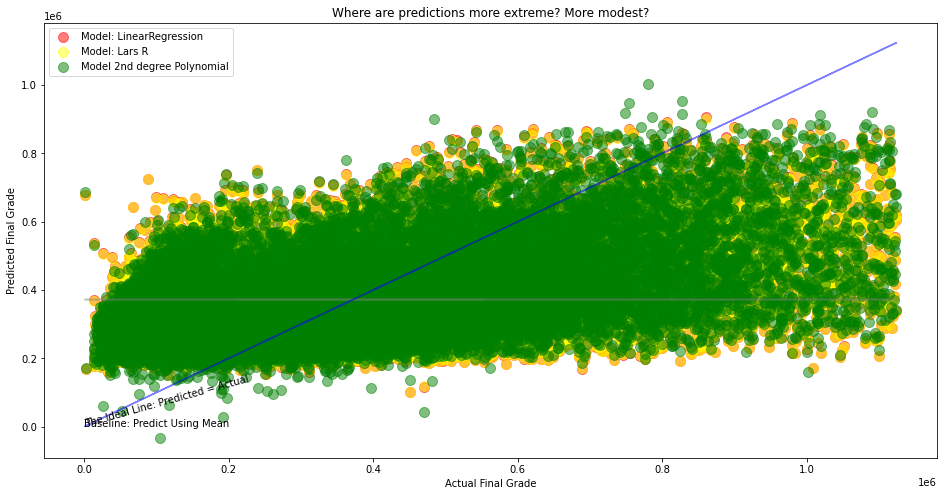

In [98]:
plt.figure(figsize=(16,8))
plt.plot(y_train.tax_value, y_train.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_train.tax_value, y_train.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_train.tax_value, y_train.tax_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_train.tax_value, y_train.tax_pred_lars, 
           alpha=.5, color="yellow", s=100, label="Model: Lars R")
plt.scatter(y_train.tax_value, y_train.tax_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

# Plotting Residuals

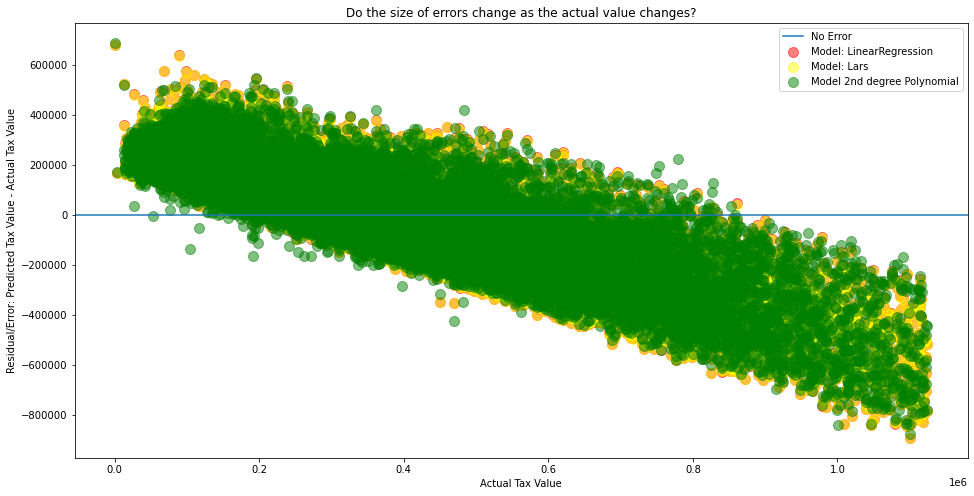

In [99]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_train.tax_value, y_train.tax_pred_lm - y_train.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_train.tax_value, y_train.tax_pred_lars - y_train.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: Lars")
plt.scatter(y_train.tax_value, y_train.tax_pred_lm2 - y_train.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

In [100]:
# Takaways as prices increase, the model is becoming less effective
# it is under predicting values at higher prices

# histo of actual vs predicted

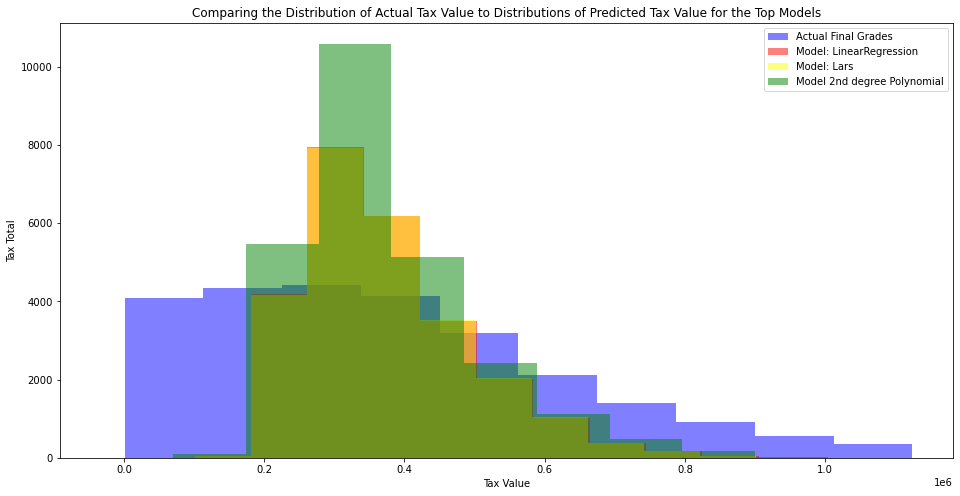

In [101]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_train.tax_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_train.tax_pred_lars, color='yellow', alpha=.5, label="Model: Lars")
plt.hist(y_train.tax_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Tax Total")
plt.title("Comparing the Distribution of Actual Tax Value to Distributions of Predicted Tax Value for the Top Models")
plt.legend()
plt.show()